<a href="https://colab.research.google.com/github/Schnitze1/COS30049-Misinformation-Detection-on-Social-Media-text-user-metadata-/blob/main/Additional_MultiTopic_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cybersecurity Data Preprocessing — Multi-Project Workshop (Jupyter Notebook)

**Important:** Everything in this notebook is **OPTIONAL** and **modular**.  
Pick only the techniques that fit **your project, your data, and your goals**.  
Every step includes **“Why do this?”** so you understand the motivation.

**Project topics you can choose from:**
1. **Misinformation Detection on Social Media** (text + user metadata)
2. **Spam or Malware Detection** (text emails/SMS + static file hints)
3. **Detecting Software Vulnerabilities** (source code as text + simple AST/rules)
4. **Network Traffic Classification for Anomaly Detection** (flows/logs)

**How to use this notebook**
- Skim Section 0, then jump directly to **ONE** of Sections 1–4 that matches your project.  
- Each section includes a tiny **synthetic data generator** (no internet required) and **baseline code** you may keep or delete.  
- For every technique, read **Why do this?** first. If it helps **your** data, keep it; otherwise skip.


## Section 0 — Setup & Utilities (OPTIONAL)

> **All utilities here are optional.** Import only what you need.

In [ ]:
import pandas as pd
import numpy as np
import re, math, hashlib, ast, sys, io, random
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

random.seed(7); np.random.seed(7)

def sha256_str(s: str) -> str:
    """One-way hashing helper for anonymization (OPTIONAL)."""
    return hashlib.sha256(s.encode('utf-8')).hexdigest()

def simple_entropy(byte_vals):
    """Shannon entropy estimator for a bytes-like sequence (OPTIONAL)."""
    if byte_vals is None or len(byte_vals)==0:
        return 0.0
    counts = np.bincount(byte_vals, minlength=256)
    p = counts / counts.sum()
    nz = p[p>0]
    return float(-(nz * np.log2(nz)).sum())

def clean_text_basic(text: str) -> str:
    """Basic, OPTIONAL cleaner for social/email text. Keeps semantics coarse."""
    if not isinstance(text, str):
        return ""
    t = re.sub(r"http\S+","", text)        # remove URLs
    t = re.sub(r"@\w+","", t)              # remove mentions
    t = t.replace("#","")                  # remove hashtag symbol (keep words)
    t = re.sub(r"[^\w\s]"," ", t)          # strip heavy punctuation
    t = re.sub(r"\s+"," ", t).strip().lower()
    return t

def train_lr_text(texts, labels, use_tfidf=True):
    """Tiny baseline: text -> vectorizer -> LR (class_weight='balanced')."""
    vec = (TfidfVectorizer if use_tfidf else CountVectorizer)(min_df=2, ngram_range=(1,2))
    X = vec.fit_transform(texts)
    Xtr, Xte, ytr, yte = train_test_split(X, labels, test_size=0.25, random_state=42, stratify=labels)
    clf = LogisticRegression(max_iter=300, class_weight='balanced')
    clf.fit(Xtr, ytr)
    ypred = clf.predict(Xte)
    print(confusion_matrix(yte, ypred))
    print(classification_report(yte, ypred, digits=3))
    return vec, clf

def train_lr_numeric(X, y):
    """Tiny baseline: numeric -> scale -> LR (balanced)."""
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)
    clf = LogisticRegression(max_iter=300, class_weight='balanced')
    clf.fit(Xtr_s, ytr)
    ypred = clf.predict(Xte_s)
    print(confusion_matrix(yte, ypred))
    print(classification_report(yte, ypred, digits=3))
    return scaler, clf


---

## Section 1 — Misinformation Detection on Social Media (OPTIONAL)

**Data you might have:** posts/tweets, text content, hashtags, user profile stats (age of account, followers), engagement (likes/retweets).  

**Reminder:** Everything below is **optional**. You should **pick** only what helps your dataset.

### 1.1 Load or Simulate Data (OPTIONAL)
- If you have real data, **replace** the simulation cell with your loader.  
- The simulator only helps you practice the pipeline.


In [ ]:
# OPTIONAL: simulate a small, imbalanced social-media dataset for practice
N = 1000
def rand_post():
    base = random.choice([
        "Breaking news update on health policy",
        "You won't believe this shocking claim",
        "Experts discuss vaccine effectiveness",
        "Rumor says the bank will close tomorrow",
        "Officials confirm the new rule for travel"
    ])
    # Add noise/hashtags/URLs to mimic real posts
    if random.random() < 0.5:
        base += " #update"
    if random.random() < 0.3:
        base += " visit http://example.com/info"
    return base

texts = [rand_post() for _ in range(N)]
# Label: 1=misinformation (rare), 0=benign
labels = np.array([1 if random.random()<0.12 else 0 for _ in range(N)])

misinfo_df = pd.DataFrame({"text": texts, "label": labels})
misinfo_df.head()


,text,label
0,Experts discuss vaccine effectiveness,0
1,Breaking news update on health policy #update,0
2,Experts discuss vaccine effectiveness,1
3,You won't believe this shocking claim #update,0
4,Breaking news update on health policy #update,1


In [ ]:
### 1.2 Text Normalization (OPTIONAL — choose what you need)

# Why do this?
# - To reduce superficial variability (URLs, casing, symbols) that hurt generalization.
# - Keep it light; over-cleaning can remove useful signals (e.g., sarcasm markers, emoji).

misinfo_df['clean_text'] = misinfo_df['text'].apply(clean_text_basic)
misinfo_df[['text','clean_text','label']].head(5)


,text,clean_text,label
0,Experts discuss vaccine effectiveness,experts discuss vaccine effectiveness,0
1,Breaking news update on health policy #update,breaking news update on health policy update,0
2,Experts discuss vaccine effectiveness,experts discuss vaccine effectiveness,1
3,You won't believe this shocking claim #update,you won t believe this shocking claim update,0
4,Breaking news update on health policy #update,breaking news update on health policy update,1


In [ ]:
### 1.3 Lightweight Metadata Features (OPTIONAL)
# Why do this?
# - In real data, misinformation often correlates with account age or engagement patterns.
# - With no real metadata here, we simulate coarse proxies (e.g., pseudo follower ratio).

# Simulate a toy "follower_ratio" that is weakly correlated with label
np.random.seed(7)
misinfo_df['follower_ratio'] = np.where(misinfo_df['label']==1,
                                        np.random.beta(1,5, size=len(misinfo_df)),
                                        np.random.beta(2,2, size=len(misinfo_df)))
misinfo_df[['clean_text','follower_ratio','label']].head(5)


,clean_text,follower_ratio,label
0,experts discuss vaccine effectiveness,0.400339,0
1,breaking news update on health policy update,0.772996,0
2,experts discuss vaccine effectiveness,0.138219,1
3,you won t believe this shocking claim update,0.794940,0
4,breaking news update on health policy update,0.099853,1


In [ ]:
### 1.4 Quick Baseline (OPTIONAL)
# Why do this?
# - Establish a sanity-check baseline before complex models.
# - Use class_weight='balanced' because positive class is rare.

vec, clf = train_lr_text(misinfo_df['clean_text'], misinfo_df['label'], use_tfidf=True)


[[109 112]
 [ 18  11]]
              precision    recall  f1-score   support

           0      0.858     0.493     0.626       221
           1      0.089     0.379     0.145        29

    accuracy                          0.480       250
   macro avg      0.474     0.436     0.386       250
weighted avg      0.769     0.480     0.571       250



---

## Section 2 — Spam or Malware Detection (OPTIONAL)

**Data you might have:** email/SMS text, headers, attachments; or file samples with static/dynamic features.

**Reminder:** Pick only what applies to your dataset.

### 2.1 Email/SMS Spam — Load or Simulate (OPTIONAL)


In [ ]:
# OPTIONAL: simulate a small email-like dataset
M = 800
def rand_mail():
    base = random.choice([
        "Dear user, you have won a prize! claim now",
        "Meeting agenda attached for project update",
        "Urgent: verify your bank account immediately",
        "Lunch plans? Let me know your preference",
        "Free gift card available: update your info"
    ])
    # Add links occasionally
    if random.random() < 0.4:
        base += " http://promo.example.com"
    return base

mail_texts = [rand_mail() for _ in range(M)]
mail_labels = np.array([1 if random.random()<0.25 else 0 for _ in range(M)])  # 1=spam
spam_df = pd.DataFrame({"body": mail_texts, "label": mail_labels})
spam_df.head()


,body,label
0,"Dear user, you have won a prize! claim now",1
1,Meeting agenda attached for project update,0
2,Free gift card available: update your info,0
3,Lunch plans? Let me know your preference http:...,0
4,Lunch plans? Let me know your preference http:...,0


In [ ]:
### 2.2 Text Feature Hints (OPTIONAL)
# Why do this?
# - Spam often has specific lexical cues (free, win, urgent) and many links.
# - But rules can be gamed; combine with statistical features.

susp_words = ['free','win','urgent','bank','prize','verify','account','gift']
spam_df['clean_body'] = spam_df['body'].apply(clean_text_basic)
spam_df['num_links'] = spam_df['body'].str.count(r"http")
spam_df['has_susp'] = spam_df['clean_body'].apply(lambda x: int(any(w in x for w in susp_words)))
spam_df[['clean_body','num_links','has_susp','label']].head(5)


,clean_body,num_links,has_susp,label
0,dear user you have won a prize claim now,0,1,1
1,meeting agenda attached for project update,0,0,0
2,free gift card available update your info,0,1,0
3,lunch plans let me know your preference,1,0,0
4,lunch plans let me know your preference,1,0,0


In [ ]:
### 2.3 Quick Baseline for Spam Text (OPTIONAL)
vec_spam, clf_spam = train_lr_text(spam_df['clean_body'], spam_df['label'], use_tfidf=True)


[[85 63]
 [37 15]]
              precision    recall  f1-score   support

           0      0.697     0.574     0.630       148
           1      0.192     0.288     0.231        52

    accuracy                          0.500       200
   macro avg      0.445     0.431     0.430       200
weighted avg      0.566     0.500     0.526       200



### 2.4 Malware — Simple Static Features (OPTIONAL)
**If your project is malware classification**, consider static features:
- file size, Shannon entropy, imported APIs, string patterns.

**Why do this?**
- Packed/encrypted malware often shows **higher entropy**.
- Suspicious API usage (e.g., `VirtualAlloc`, `CreateRemoteThread`) can be strong indicators.


In [ ]:
# OPTIONAL: simulate rough "files" as byte arrays with different entropy patterns
K = 300
files = []
labels_mw = []  # 1=malicious
for i in range(K):
    if random.random() < 0.35:  # malicious
        size = random.randint(2000, 12000)
        # high-entropy-ish: sample bytes uniformly
        data = np.random.randint(0, 256, size=size, dtype=np.uint8)
        labels_mw.append(1)
    else:
        size = random.randint(1000, 8000)
        # lower-entropy-ish: biased distribution
        data = np.random.binomial(255, 0.1, size=size).astype(np.uint8)
        labels_mw.append(0)
    files.append(data)

mw_size = [len(b) for b in files]
mw_entropy = [simple_entropy(b) for b in files]
mw_df = pd.DataFrame({"size": mw_size, "entropy": mw_entropy, "label": labels_mw})
mw_df.head()


,size,entropy,label
0,4001,7.953266,1
1,2015,7.917522,1
2,5487,4.303193,0
3,7119,4.308464,0
4,7398,7.975832,1


[[48  0]
 [ 0 27]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        48
           1      1.000     1.000     1.000        27

    accuracy                          1.000        75
   macro avg      1.000     1.000     1.000        75
weighted avg      1.000     1.000     1.000        75



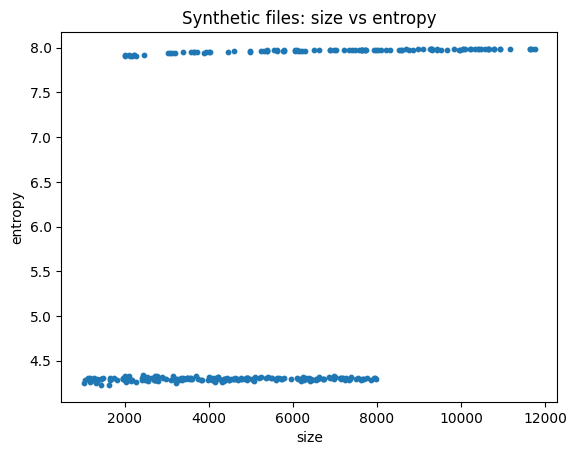

In [ ]:
# OPTIONAL: quick numeric baseline on static features
X = mw_df[['size','entropy']].values
y = mw_df['label'].values
scaler_mw, clf_mw = train_lr_numeric(X, y)

# Simple scatter to visualize (OPTIONAL)
plt.figure()
plt.scatter(mw_df['size'], mw_df['entropy'], s=10)
plt.xlabel('size'); plt.ylabel('entropy'); plt.title('Synthetic files: size vs entropy')
plt.show()


---

## Section 3 — Detecting Software Vulnerabilities (OPTIONAL)

**Data you might have:** source code (functions/snippets), labels for vulnerable/safe.

**Reminder:** Techniques below are mix-and-match **options**. Start simple; only add what helps.

### 3.1 Load or Simulate Code Snippets (OPTIONAL)


In [ ]:
# OPTIONAL: toy Python functions with "risky" patterns vs safe patterns
S = 400
templates_vuln = [
    "def do_eval(x):\n    return eval(x)\n",
    "import os\n\ndef runcmd(cmd):\n    os.system(cmd)\n",
    "import subprocess\n\ndef runp(cmd):\n    return subprocess.Popen(cmd, shell=True)\n"
]
templates_safe = [
    "def add(a,b):\n    return a+b\n",
    "def sanitize(x):\n    return str(x).replace('<','').replace('>','')\n",
    "def mean(lst):\n    s = 0\n    for v in lst:\n        s += v\n    return s/len(lst)\n"
]

codes, yv = [], []
for i in range(S):
    if random.random() < 0.35:  # vulnerable
        codes.append(random.choice(templates_vuln))
        yv.append(1)
    else:
        codes.append(random.choice(templates_safe))
        yv.append(0)

vuln_df = pd.DataFrame({"code": codes, "label": yv})
vuln_df.head()


,code,label
0,"def add(a,b):\n return a+b\n",0
1,def mean(lst):\n s = 0\n for v in lst:\n...,0
2,def mean(lst):\n s = 0\n for v in lst:\n...,0
3,def sanitize(x):\n return str(x).replace('<...,0
4,import os\n\ndef runcmd(cmd):\n os.system(c...,1


In [ ]:
### 3.2 OPTIONAL Feature Ideas (Why + minimal demos)

# A) Tokenization (OPTIONAL)
# Why do this?
# - Normalizes code into tokens so ML models see structure beyond raw text.
# - Reduces sensitivity to variable names and spacing.

def tokenize_code(code_str):
    return re.findall(r"[A-Za-z_]\w*|\S", code_str)

vuln_df['tokens'] = vuln_df['code'].apply(tokenize_code)

# B) Rule-based flags (OPTIONAL)
# Why do this?
# - Cheap, interpretable signals for obviously risky APIs/patterns.

risk_patterns = [r"\beval\s*\(", r"os\.system\s*\(", r"subprocess\.Popen\s*\(.*shell\s*=\s*True"]
def has_risky_pattern(s):
    return int(any(re.search(p, s) for p in risk_patterns))

vuln_df['risky_flag'] = vuln_df['code'].apply(has_risky_pattern)

# C) AST-derived features (OPTIONAL)
# Why do this?
# - Abstract Syntax Tree provides structural features (calls, branches, loops).

def ast_features(code_str):
    try:
        tree = ast.parse(code_str)
    except Exception:
        return {"num_calls":0, "num_if":0, "num_for":0, "num_while":0}
    calls = sum(isinstance(n, ast.Call) for n in ast.walk(tree))
    num_if = sum(isinstance(n, ast.If) for n in ast.walk(tree))
    num_for = sum(isinstance(n, ast.For) for n in ast.walk(tree))
    num_while = sum(isinstance(n, ast.While) for n in ast.walk(tree))
    return {"num_calls":calls,"num_if":num_if,"num_for":num_for,"num_while":num_while}

ast_feat_df = vuln_df['code'].apply(ast_features).apply(pd.Series)
vuln_feat = pd.concat([ast_feat_df, vuln_df[['risky_flag']]], axis=1)
vuln_feat.head()


,num_calls,num_if,num_for,num_while,risky_flag
0,0,0,0,0,0
1,1,0,1,0,0
2,1,0,1,0,0
3,3,0,0,0,0
4,1,0,0,0,1


In [ ]:
### 3.3 Quick Baselines (OPTIONAL)

# Text-based model on code (bag-of-words/TF-IDF) — OPTIONAL
vec_code, clf_code = train_lr_text(vuln_df['code'], vuln_df['label'], use_tfidf=True)

# Numeric model on AST + rules — OPTIONAL
Xv = vuln_feat.values
yv = vuln_df['label'].values
scaler_v, clf_v = train_lr_numeric(Xv, yv)


[[64  0]
 [ 0 36]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        64
           1      1.000     1.000     1.000        36

    accuracy                          1.000       100
   macro avg      1.000     1.000     1.000       100
weighted avg      1.000     1.000     1.000       100

[[64  0]
 [ 0 36]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        64
           1      1.000     1.000     1.000        36

    accuracy                          1.000       100
   macro avg      1.000     1.000     1.000       100
weighted avg      1.000     1.000     1.000       100



---

## Section 4 — Network Traffic Classification for Anomaly Detection (OPTIONAL)

**Data you might have:** PCAP/NetFlow exports, firewall/IDS logs, HTTP proxy logs.

**Reminder:** Run only the parts relevant to your dataset.

### 4.1 Load or Simulate Network Logs (OPTIONAL)


In [ ]:
# OPTIONAL: small synthetic flow-like table
from datetime import datetime, timedelta

def rand_ip():
    return ".".join(str(np.random.randint(1,255)) for _ in range(4))

protocols = ["TCP","UDP","ICMP"]
def rand_port():
    return int(np.random.choice([80,443,22,25,53,8080,3306,3389,123,1723,5060, np.random.randint(1024,65535)]))

def rand_url():
    base = "".join(random.choices("abcdefghijklmnopqrstuvwxyz", k=np.random.randint(5,12)))
    tld = np.random.choice([".com",".net",".org",".xyz",".top",".ru",".cn",".co",".io"])
    path_len = np.random.randint(0,5)
    path = "/".join("".join(random.choices("abcdefghijklmnopqrstuvwxyz0123456789", k=np.random.randint(3,10))) for _ in range(path_len))
    if np.random.rand() < 0.25:
        path += ("" if not path else "/") + random.choice(["login","verify","account","secure","update","free","win","bank"])
    return f"http://{base}{tld}/" + path if path else f"http://{base}{tld}"

Nflows = 900
rows = []
for i in range(Nflows):
    ts = datetime(2025,1,1) + timedelta(seconds=int(np.random.exponential(3000)))
    src_ip, dst_ip = rand_ip(), rand_ip()
    src_port, dst_port = rand_port(), rand_port()
    proto = np.random.choice(protocols, p=[0.7,0.25,0.05])
    url = rand_url() if np.random.rand() < 0.6 else ""
    byte_count = int(abs(np.random.normal(1500,800))) + np.random.randint(0,15000)
    label = 1 if np.random.rand() < 0.1 else 0  # anomaly rare
    if np.random.rand() < 0.05:
        byte_count = 0  # invalid/empty
    rows.append([ts.isoformat(), src_ip, dst_ip, src_port, dst_port, proto, url, byte_count, label])

net_df = pd.DataFrame(rows, columns=['timestamp','src_ip','dst_ip','src_port','dst_port','protocol','url','bytes','label'])
net_df.head()


,timestamp,src_ip,dst_ip,src_port,dst_port,protocol,url,bytes,label
0,2025-01-01T00:00:46,129.227.46.8,46.6.82.26,123,53,UDP,http://jazudcfr.org/earaj/nhajilom/la40rai6/qh36,9559,0
1,2025-01-01T00:07:21,207.218.117.130,149.122.119.5,51355,1723,UDP,,15128,0
2,2025-01-01T01:44:40,153.143.163.79,196.221.148.146,443,3389,TCP,,1608,0
3,2025-01-01T00:18:15,36.64.93.103,159.127.109.245,5060,1723,TCP,http://dnodiq.org/yww/nca45/update,12594,0
4,2025-01-01T00:17:55,8.105.221.154,60.157.250.218,3389,8080,ICMP,http://buejfw.com/33n7juyin/d2gekx/account,15697,0


In [ ]:
### 4.2 Cleaning & Privacy (OPTIONAL)
# Why do this?
# - Remove invalid noise (e.g., empty flows), normalize time and protocol fields.
# - Anonymize IPs before sharing to protect privacy.

net_df['timestamp'] = pd.to_datetime(net_df['timestamp'], utc=True, errors='coerce')
net_df = net_df.dropna(subset=['timestamp'])
net_df = net_df[net_df['bytes'] > 0]
net_df['protocol'] = net_df['protocol'].str.upper().str.strip()
net_df = net_df[net_df['protocol'].isin(['TCP','UDP','ICMP'])]

net_df['src_ip_hash'] = net_df['src_ip'].apply(sha256_str)
net_df['dst_ip_hash'] = net_df['dst_ip'].apply(sha256_str)
net_df[['src_ip','dst_ip','src_ip_hash','dst_ip_hash']].head(5)


,src_ip,dst_ip,src_ip_hash,dst_ip_hash
0,129.227.46.8,46.6.82.26,0a1c6df1290b8f77ef0d7d6cc6c6228567f22316f2daeb...,f9ea3f634b5e7a71ba6c299f497d8bcbbd8641f4c7be9e...
1,207.218.117.130,149.122.119.5,40fd8a2852d2977ca6070de45e1379b3cb814ea03e1279...,55bb0bf90d0c58c3f8142e24671f2eee65ad908380be88...
2,153.143.163.79,196.221.148.146,ce621eec6069536bd5c0710775114180677eed9ea2dc33...,84ffeef541f50695cbd2e5e9bf53758b8e1506d0739ed6...
3,36.64.93.103,159.127.109.245,9d00ced5ef2c5c2ebe78387f1188fe8ba78dde1d5587f4...,53dc4b648b7a0d2df6f3e43acbeadd161dd66c0bdf7cb3...
4,8.105.221.154,60.157.250.218,fb6308bc9b9dddef3eef82a1cf7c1a5875890946a71351...,eaba5feee4a5f39d3304c9f4b3786fcbb48bc389dd5104...


In [ ]:
### 4.3 Feature Ideas (OPTIONAL)
# Why do this?
# - Security-specific heuristics can boost signal early on (URL cues, port categories).

sus_words = set(['login','verify','account','secure','update','free','win','bank'])
bad_tlds = set(['.ru','.cn','.top','.xyz'])
ip_in_host_regex = re.compile(r"(\d{1,3}\.){3}\d{1,3}")

def url_features(u: str):
    if not isinstance(u, str):
        return {'url_len':0,'url_num_dots':0,'url_num_digits':0,'url_has_ip':0,'url_has_susp':0,'url_bad_tld':0}
    url = u.strip().lower()
    url_len = len(url)
    url_num_dots = url.count('.')
    url_num_digits = sum(ch.isdigit() for ch in url)
    url_has_ip = 1 if ip_in_host_regex.search(url) else 0
    url_has_susp = 1 if any(w in url for w in sus_words) else 0
    url_bad_tld = 1 if any(url.endswith(t) for t in bad_tlds) else 0
    return {'url_len':url_len,'url_num_dots':url_num_dots,'url_num_digits':url_num_digits,
            'url_has_ip':url_has_ip,'url_has_susp':url_has_susp,'url_bad_tld':url_bad_tld}

uf = net_df['url'].apply(url_features).apply(pd.Series)
net_df = pd.concat([net_df, uf], axis=1)

def port_category(p):
    if p in [80,443,8080]: return 'web'
    if p in [22]: return 'ssh'
    if p in [25,587,465]: return 'mail'
    if p in [53]: return 'dns'
    if p in [3306,5432]: return 'db'
    return 'other'

net_df['src_port_cat'] = net_df['src_port'].apply(port_category)
net_df['dst_port_cat'] = net_df['dst_port'].apply(port_category)

proto_ohe = pd.get_dummies(net_df['protocol'], prefix='proto')
srcp_ohe = pd.get_dummies(net_df['src_port_cat'], prefix='srcp')
dstp_ohe = pd.get_dummies(net_df['dst_port_cat'], prefix='dstp')

net_df['bytes_log1p'] = np.log1p(net_df['bytes'])

net_feat = pd.concat([
    net_df[['url_len','url_num_dots','url_num_digits','url_has_ip','url_has_susp','url_bad_tld','bytes_log1p']],
    proto_ohe, srcp_ohe, dstp_ohe
], axis=1).fillna(0)

net_feat.head()


,url_len,url_num_dots,url_num_digits,url_has_ip,url_has_susp,url_bad_tld,bytes_log1p,proto_ICMP,proto_TCP,proto_UDP,...,srcp_mail,srcp_other,srcp_ssh,srcp_web,dstp_db,dstp_dns,dstp_mail,dstp_other,dstp_ssh,dstp_web
0,48,1,5,0,0,0,9.165343,False,False,True,...,False,True,False,False,False,True,False,False,False,False
1,0,0,0,0,0,0,9.624369,False,False,True,...,False,True,False,False,False,False,False,True,False,False
2,0,0,0,0,0,0,7.383368,False,True,False,...,False,False,False,True,False,False,False,True,False,False
3,34,1,2,0,1,0,9.441055,False,True,False,...,False,True,False,False,False,False,False,True,False,False
4,42,1,4,0,1,0,9.661289,True,False,False,...,False,True,False,False,False,False,False,False,False,True


In [ ]:
### 4.4 Quick Baseline (OPTIONAL)
Xn = net_feat.values
yn = net_df['label'].values
scaler_n, clf_n = train_lr_numeric(Xn, yn)


[[111  84]
 [ 12   5]]
              precision    recall  f1-score   support

           0      0.902     0.569     0.698       195
           1      0.056     0.294     0.094        17

    accuracy                          0.547       212
   macro avg      0.479     0.432     0.396       212
weighted avg      0.835     0.547     0.650       212



---

## Section 5 — Practical Guidance (OPTIONAL)
- **Start simple.** Use a tiny baseline to establish signal before complex models.
- **Document choices.** For every preprocessing step you keep, write *why* it helps *your data*.
- **Privacy first.** Hash IPs/emails/usernames before sharing any dataset.
- **Class imbalance.** Prefer recall-oriented metrics in detection tasks; consider class weights or sampling.
- **Reproducibility.** Fix random seeds and save preprocessing code as functions.

### Suggested self-review
1. A short **Data Card** explaining which optional steps you chose and why.
2. A minimal **reproduction notebook** (this file) with only the steps you used.
3. A **model card** stating metrics (precision/recall/F1) and imbalance handling.
